In [1]:
%load_ext autoreload
%load_ext jupyternotify
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from multiprocessing import Process
from tqdm import tqdm_notebook as tqdm
import pickle
from pathlib import Path
from nuscenes import NuScenes
from scipy.spatial.transform import Rotation as R 
from math import cos, sin, pi
from lyft_dataset_sdk.lyftdataset import *
from nuscenes.eval.detection.utils import *
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from lyft_dataset_sdk.eval.detection import mAP_evaluation

In [3]:
import torch
from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)
from second.data.preprocess import merge_second_batch, merge_second_batch_multigpu
from second.pytorch.train import build_network, example_convert_to_torch
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool

## Read Config file

In [4]:
config_path = "/home/keceli/3d-data/second/configs/all.fhd.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.eval_input_reader
model_cfg = config.model.second
config_tool.change_detection_range_v2(model_cfg, [-50, -50, 50, 50])
#Uncomment below one, if you have gpu.
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Build Network, Target Assigner and Voxel Generator

In [5]:
phase = 'train'
# phase = 'test'
folder = 'test' if phase == 'test' else 'train'
root = '/home/keceli/3d-data/'
info_path = root + f'3d-data/lyft/{folder}/infos_{phase}.pkl'
root_path = input_cfg.dataset.kitti_root_path

with open(info_path, 'rb') as f:
    infos = pickle.load(f)    
print(info_path)

/home/keceli/3d-data/train/infos_train.pkl


In [6]:
classes = ['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle', 'other_vehicle', 'motorcycle', 'pedestrian', 'truck']

In [7]:
token2info = {}
for info in infos['infos']:
    token2info[info['token']] = info

In [8]:
net = build_network(config.model.second).to(device).float().eval()
net.load_state_dict(torch.load(ckpt_path))
eval_input_cfg = config.eval_input_reader
eval_input_cfg.dataset.kitti_root_path = root_path
eval_input_cfg.dataset.kitti_info_path = info_path
batch_size = 4
num_workers = 6
dataset = input_reader_builder.build(
    eval_input_cfg,
    config.model.second,
    training=False,
    voxel_generator=net.voxel_generator,
    target_assigner=net.target_assigner)#.dataset
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size, # only support multi-gpu train
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    collate_fn=merge_second_batch)

classes = net.target_assigner.classes
np.array(classes)

array(['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle',
       'other_vehicle', 'motorcycle', 'pedestrian', 'truck'], dtype='<U17')

### Some Utility Functions
Some functions in order to work around with pre-trained models.

In [10]:
def thresholded_pred(pred, threshold):
    pred = deepcopy(pred)
    try:
        box3d = pred["box3d_lidar"].detach().cpu().numpy()
        scores = pred["scores"].detach().cpu().numpy()
        labels = pred["label_preds"].detach().cpu().numpy()
    except:
        box3d = pred["box3d_lidar"]#.detach().cpu().numpy()
        scores = pred["scores"]#.detach().cpu().numpy()
        labels = pred["label_preds"]#.detach().cpu().numpy()
        pass
    idx = np.where(scores > threshold)[0]
    # filter low score ones
    box3d = box3d[idx, :]
    # label is one-dim
    labels = np.take(labels, idx)
    scores = np.take(scores, idx)
    pred['box3d_lidar'] = box3d
    pred['scores'] = scores
    pred['label_preds'] = labels
    return pred

In [11]:
def to_glb(box, info):
    box.rotate(Quaternion(info['lidar2ego_rotation']))
    box.translate(np.array(info['lidar2ego_translation']))
    '''
    #Deprecated, ignore for atm..
    # filter det in ego.
    cls_range_map = eval_detection_configs[eval_version]["class_range"]
    radius = np.linalg.norm(box.center[:2], 2)
    det_range = cls_range_map[classes[box.label]]
    if radius > det_range:
        continue
    '''
    box.rotate(Quaternion(info['ego2global_rotation']))
    box.translate(np.array(info['ego2global_translation']))
    return box

In [12]:
def get_pred_glb(pred, sample_token, form='str'):
    boxes_lidar = pred["box3d_lidar"]
    boxes_class = pred["label_preds"]
    scores = pred['scores']
    preds_classes = [classes[x] for x in boxes_class]
    box_centers = boxes_lidar[:, :3]
    box_yaws = boxes_lidar[:, -1]
    box_wlh = boxes_lidar[:, 3:6]
    info = token2info[sample_token] # a sample token
    boxes = []
    pred_str = ''
    for idx in range(len(boxes_lidar)):
        translation = box_centers[idx]
        yaw = - box_yaws[idx] - pi/2 # second to lyft format
        size = box_wlh[idx]
        name = preds_classes[idx]
        detection_score = scores[idx]
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        box = Box(
            center=box_centers[idx],
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            token=sample_token
        )
        #return box
        box = to_glb(box, info)
        if form=='str':
            pred =  str(box.score) + ' ' + str(box.center[0])  + ' '  + \
                    str(box.center[1]) + ' '  + str(box.center[2]) + ' '  + \
                    str(box.wlh[0]) + ' ' \
                    + str(box.wlh[1]) + ' '  + str(box.wlh[2]) + ' ' + str(quaternion_yaw(box.orientation)) + ' ' \
                    + str(name) + ' ' 
            pred_str += pred
        else:
            boxes.append(box)
    if form=='str':
        return pred_str.strip()
    else:
        return boxes

In [13]:
def torch2np(pred):
    f = lambda x: x.detach().cpu().numpy()
    pred["box3d_lidar"] = f(pred["box3d_lidar"])
    pred["scores"] = f(pred["scores"])
    pred["label_preds"] = f(pred["label_preds"])
    return pred

Now, we will generate raw predictions and save them in pickle format for serializing

In [14]:
%%notify
detections = []
#tokens = []
tk0 = tqdm(dataloader, total=len(dataloader))
for idx, examples in enumerate(tk0):
    try:
        example_torch = example_convert_to_torch(examples, device=device)
        dets = net(example_torch)
        detections += [torch2np(det) for det in dets]
    except Exception as e:
        print(e)
        import pdb; pdb.set_trace()

100%|██████████| 9261/9261 [25:41<00:00,  6.01it/s]


<IPython.core.display.Javascript object>

In [15]:
det_folder = os.path.join(os.path.dirname(ckpt_path), 'detections')
os.makedirs(det_folder, exist_ok=True)
det_file = os.path.join(det_folder, f"{ckpt_path.split('/')[-1].split('.')[0]}_{phase}.pkl")
print(det_file)

with open(det_file, 'wb') as f:
    pickle.dump(detections, f)
print(f'Saved detections at {det_file}')
print(f'python eval.py --det_file {det_file}  --phase {phase}') # eval.py command

/home/keceli/3d-data/second_test/all.pp.mida/detections/voxelnet-125333_train.pkl
Saved detections at /home/keceli/3d-data/second_test/all.pp.mida/detections/voxelnet-125333_train.pkl
python eval.py --det_file /home/keceli/3d-data/second_test/all.pp.mida/detections/voxelnet-125333_train.pkl  --phase train


detection -> PredictionString

NOTE: the `detections` are in raw format

In [16]:
if phase == 'train':
    col = 'PredictionStringtest'
    df = pd.read_csv(root + '/home/keceli/3d-data/train.csv')
else:
    col = 'PredictionString'
    df = pd.read_csv(root + '/home/keceli/3d-data/sample_submission.csv')

In [17]:
%%notify
threshold = 0.2
for idx, pred in enumerate(tqdm(detections)):
    pred = thresholded_pred(pred, threshold)
    token = pred['metadata']['token']
    pred_str = get_pred_glb(pred, token)
    index = df[df['Id'] == token].index[0]
    df.loc[index, col] = pred_str

100%|██████████| 27468/27468 [04:25<00:00, 103.58it/s]


<IPython.core.display.Javascript object>

In [18]:
df.to_csv('submissions/all.pp.mida.125k.0.2.csv', index=False)

In [19]:
df.head()

,Id,PredictionString
0,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,0.9636315107345581 1544.76466039274 1371.78264...
1,a76d702996a086ecd4add92b6c533b76f0ab1dd35a4729...,0.932319164276123 1504.9430971481338 1419.3496...
2,a9919963e5cd83d12b60bb9c386869ecb4dffcf2e3c401...,0.9552755355834961 598.5396407490891 3383.4818...
3,e3f42dc16cb366723699a5e12098edb56907d676cb5720...,0.9694597125053406 1054.5954522436566 1670.093...
4,033edef20c7f951738c037c0275dc02279a15454fda3e6...,0.9616791605949402 2764.046813853137 663.42462...


### testing on val set

make sure to match kernel is predicting on train or val which one

In [21]:
phase = 'train'
data = 'v1.0-trainval' if phase=='train' else 'v1.0-test'
lyft = LyftDataset(data_path=f'../../3d-data/lyft/{phase}/', json_path=f'../../3d-data/lyft/{phase}/{data}/', verbose=0) 

In [22]:
classes = ['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle', 'other_vehicle', 'motorcycle', 'pedestrian', 'truck']
res_path = '/home/keceli/3d-data/second.pytorch/result.pkl'
info_path = '/home/keceli/3d-data/second.pytorch/infos_val.pkl'
with open(res_path, 'rb') as f:
    results = pickle.load(f)#['infos']
    
with open(info_path, 'rb') as f:
    gt = pickle.load(f)['infos']
df = pd.read_csv('/home/keceli/3d-data/train.csv')

# info_val.pkl and result.pkl are a list of dictionaries, which are out of order, sorting them acc to token
gt = sorted(gt, key=lambda x: x['token'])
results = sorted(results, key=lambda x: x['metadata']['token'])
# sanity check
for i in range(len(gt)):
    assert gt[i]['token'] == results[i]['metadata']['token']
    results[i]['box3d_lidar'] = results[i]['box3d_lidar']#.detach().cpu().numpy()
    results[i]['scores'] = results[i]['scores'].detach()#.cpu().numpy()
    results[i]['label_preds'] = results[i]['label_preds']#.detach().cpu().numpy()

In [23]:
token2idx = {} # to match up kernel_pred_boxes
for i in range(len(gt)):
    token2idx[gt[i]['token']] = i

In [24]:
def get_pred_boxes(pred, sample_token):
    boxes_lidar = pred["box3d_lidar"]
    boxes_class = pred["label_preds"]
    scores = pred['scores']
    preds_classes = [classes[x] for x in boxes_class]
    box_centers = boxes_lidar[:, :3]
    box_yaws = boxes_lidar[:, -1]
    box_wlh = boxes_lidar[:, 3:6]
    info = token2info[sample_token] # sample token
    boxes = []
    pred_str = ''
    for idx in range(len(boxes_lidar)):
        translation = box_centers[idx]
        yaw = - box_yaws[idx] - pi/2
        size = box_wlh[idx]
        name = preds_classes[idx]
        detection_score = scores[idx]
        label = boxes_class[idx]
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        box = Box(
            center=box_centers[idx],
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            label=label,
            token=sample_token
        )
        boxes.append(box)
    return boxes

In [25]:
threshold = 0.3
token2predstr = {}
for idx in tqdm(range(len(dataset))):
    idx=100
    example = dataset[idx]
    token = example['metadata']['token']
    # don't forget to pad batch idx in coordinates
    example["coordinates"] = np.pad(
        example["coordinates"], ((0, 0), (1, 0)),
        mode='constant',
        constant_values=0)
    # don't forget to add newaxis for anchors
    example["anchors"] = example["anchors"][np.newaxis, ...]

    example_torch = example_convert_to_torch(example, device=device)
    pred = net(example_torch)[0]
    pred = thresholded_pred(pred, threshold)
    sample_token = example['metadata']['token']
    kernel_pred_boxes = get_pred_boxes(pred, sample_token)
    break
pkl_idx = token2idx[token] 
idx, pkl_idx

  0%|          | 0/4158 [00:00<?, ?it/s]


(100, 437)

we have `kernel_pred_boxes` predicted on given `idx` and `token` by this notevook, we have `results[pkl_idx]` predicted during training, we have ground truth in `gt[pkl_idx]['gt_boxes']` as actual ground truth + lyft.get_boxes for ground truth, all in lidar's FoR

In [27]:
info_gt = gt[pkl_idx].copy() # during training predictions
info_gt['gt_boxes'].shape
info_gt['gt_boxes'].shape
gt[0].keys()

dict_keys(['lidar_path', 'cam_front_path', 'token', 'sweeps', 'lidar2ego_translation', 'lidar2ego_rotation', 'ego2global_translation', 'ego2global_rotation', 'timestamp', 'gt_boxes', 'gt_names', 'gt_velocity', 'num_lidar_pts', 'num_radar_pts'])

In [29]:
def gt2Box(gt_boxes, gt_names, token):
    boxes = []
    for idx in range(len(gt_boxes)):
        center = gt_boxes[idx, :3]
        yaw = - gt_boxes[idx, 6] - pi/2
        size = gt_boxes[idx, 3:6]
        name = gt_names[idx]
        detection_score = 1.0 
        label = classes.index(name) 
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        #quat = Quaternion(axis=[0, 0, 1], radians=yaw)
        box = Box(
            center=center,
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            label=label,
            token=token
        )
        boxes.append(box)
    return boxes

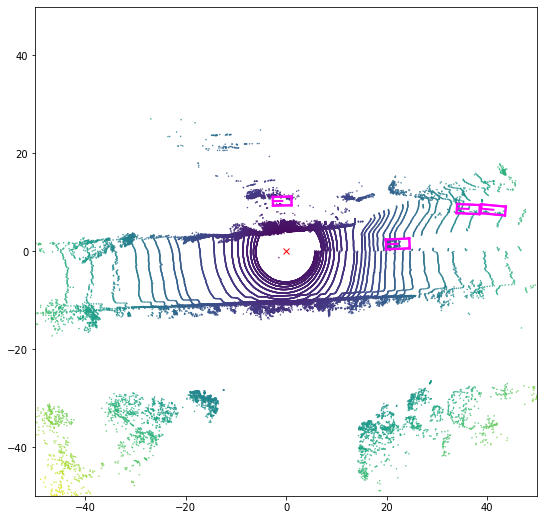

In [30]:
# plotting predicted and ground truth boxes on corresponding lidar point cloud
# pred boxes in lidar's FoR, we get the ground truth boxes in lidar's FoR too.
info = token2info[token]

dt_pred = results[pkl_idx].copy() # during training predictions
dt_pred = thresholded_pred(dt_pred, threshold)
dt_pred_boxes = get_pred_boxes(dt_pred, token)

gt_info = gt[pkl_idx]
info_gt_boxes = gt_info['gt_boxes'].copy() # during training predictions
info_gt_names = gt_info['gt_names'].copy() # during training predictions
info_gt_boxes = gt2Box(info_gt_boxes, info_gt_names, token)

v_path = info["lidar_path"]
points = np.fromfile(v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]
axes_limit = 50
_, ax = plt.subplots(1, 1, figsize=(9, 9))
dists = np.sqrt(np.sum(points[:, :2] ** 2, axis=1))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
ax.scatter(points[:, 0], points[:, 1], c=colors, s=0.2)
ax.plot(0, 0, "x", color="red")
# Limit visible range.
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)

# plot notebook predictions
for pbox in kernel_pred_boxes:
#     print(pbox)
    break
    c = np.array(lyft.explorer.get_color('cone')) / 255.0 # black
    pbox.render(ax, view=np.eye(4), colors=(c, c, c)) 
    
# plot detection results.pkl 
for pbox in dt_pred_boxes:
#     print(pbox)
    break
    c = np.array(lyft.explorer.get_color('pedestrian')) / 255.0 # Blue 
    pbox.render(ax, view=np.eye(4), colors=(c, c, c)) 
    
# plot ground truth from info.pkl 
for pbox in info_gt_boxes:
#     print(pbox)
    break
    c = np.array(lyft.explorer.get_color('vehicle.bicycle')) / 255.0 # Red 
    pbox.render(ax, view=np.eye(4), colors=(c, c, c)) 

lidar_token = lyft.get('sample', info['token'])['data']['LIDAR_TOP']
_, gt_boxes, _ = lyft.get_sample_data(lidar_token, flat_vehicle_coordinates=False) # notice flat_vehicle_coordinates=False 
for box in gt_boxes:
#     print(box)
#     break
    c = np.array(lyft.explorer.get_color('animal')) / 255.0 # magenta 
    box.render(ax, view=np.eye(4), colors=(c, c, c))

Conclusion
* The `results.pkl` generated during training are more or less same as predictions made by this notebook
* Now we will predict on val set, get them to global, compare with ground truth

In [31]:
# let's transform boxes from lidar's to global 
glb_pboxes = [to_glb(box, info) for box in pred_boxes]
glb_gboxes = [to_glb(box, info) for box in gt_boxes]

In [32]:
def toBox3D(box, info):
    return mAP_evaluation.Box3D(
                sample_token=info['token'],
                translation=box.center,
                size=box.wlh,
                rotation=box.orientation.elements,
                name=box.name
            )

In [33]:
pboxes = [toBox3D(box, info).serialize() for box in glb_pboxes]
gboxes = [toBox3D(box, info).serialize() for box in glb_gboxes]

In [34]:
iou_threshold = 0.5
gt_by_class_name = mAP_evaluation.group_by_key(gboxes, "name")
pred_by_class_name = mAP_evaluation.group_by_key(pboxes, "name")

In [35]:
for key in gt_by_class_name.keys():
    print('gt:', key, len(gt_by_class_name[key]))
for key in pred_by_class_name.keys():
    print('pred', key, len(pred_by_class_name[key]))

gt: other_vehicle 5
gt: car 30
gt: bus 2
pred car 19
pred other_vehicle 2


In [36]:
average_precisions = np.zeros(len(classes))

for class_id, class_name in enumerate(classes):
    if class_name in pred_by_class_name and class_name in gt_by_class_name:
        recalls, precisions, average_precision = mAP_evaluation.recall_precision(
            gt_by_class_name[class_name], pred_by_class_name[class_name], iou_threshold
        )
        average_precisions[class_id] = average_precision        

In [37]:
average_precisions

array([0.52745098, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

### validation df pred and ground truth

In [39]:
val_df = df[df.PredictionStringtest.notna()]
pred_df = val_df.copy()

In [40]:
pred_df.head()

,Id,PredictionString,PredictionStringtest
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...,0.9400631189346313 1172.243942155967 1637.4089...
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...,0.9210870862007141 2012.2399648592389 1117.483...
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...,0.9124171137809753 1032.1105374548263 1680.638...
6,dfd82bb815996179b54e6271dc4a11294b4c608117efb9...,2898.6051446136653 562.5216374000888 -17.87993...,0.9196555614471436 2877.3382787181454 569.8359...
7,1fcd76b821316194199d7c5f65bafff335ae2ee000d649...,1069.794595095304 1701.507156901828 -23.592075...,0.9214420914649963 1047.656502480572 1696.0528...


In [42]:
def get2Box(gt_boxes, gt_names, token, scores=None):
    boxes = []
    for idx in range(len(gt_boxes)):
        center = gt_boxes[idx, :3]
        yaw = gt_boxes[idx, 6]
        size = gt_boxes[idx, 3:6]
        name = gt_names[idx]
        detection_score = 1.0 # for ground truths 
        if scores is not None:
            detection_score = scores[idx]
        label = classes.index(name) 
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        #quat = Quaternion(axis=[0, 0, 1], radians=yaw)
        box = Box(
            center=center,
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            label=label,
            token=token
        )
        boxes.append(box)
    return boxes

In [43]:
def get_pred_gt(idx): 
    sample_token = pred_df.iloc[idx]['Id']
    ps = pred_df.iloc[idx]['PredictionString'].split()
    gt_objects = [ps[x:x+8] for x in range(0, len(ps), 8)]
    ps = pred_df.iloc[idx]['PredictionStringtest'].split()
    pred_objects = [ps[x:x+9] for x in range(0, len(ps), 9)]
    gt_boxes = np.array([list(map(float, x[0:7])) for x in gt_objects])
    gt_class = np.array([x[7] for x in gt_objects])
    pred_scores = np.array([float(x[0]) for x in pred_objects])
    pred_boxes = np.array([list(map(float, x[1:8])) for x in pred_objects])
    pred_class = np.array([x[8] for x in pred_objects])
    predBoxes = get2Box(pred_boxes, pred_class, sample_token, scores=pred_scores)
    gtBoxes = get2Box(gt_boxes, gt_class, sample_token)
    return predBoxes, gtBoxes 

In [44]:
def toBox3D(box, sample_token):
    return mAP_evaluation.Box3D(
                sample_token=sample_token,
                translation=box.center,
                size=box.wlh,
                rotation=box.orientation.elements,
                name=box.name
            )
def serialize(box):
    return {
        'sample_token': box.token,
        'translation': list(box.center),
        'size': list(box.wlh),
        'rotation': list(box.orientation.elements),
        'name': box.name,
        'score': box.score
    }

In [45]:
predBoxes = []
gtBoxes = []
for idx in tqdm(range(len(pred_df))):
    pb, gb = get_pred_gt(idx)
    predBoxes.append(pb)
    gtBoxes.append(gb)

100%|██████████| 18522/18522 [00:40<00:00, 462.62it/s] 


In [46]:
# box instance to Box3D instance -> used for mAP calculation
pboxes = []
for boxes in tqdm(predBoxes):
    for box in boxes:
        box = serialize(box)
        pboxes.append(box)
    
gboxes = []
for boxes in tqdm(gtBoxes):
    for box in boxes:
        box = serialize(box)
        gboxes.append(box)

100%|██████████| 18522/18522 [00:02<00:00, 7683.22it/s] 


In [47]:
# a dict with class name as key and all corresponding boxes in value
gt_by_class_name = mAP_evaluation.group_by_key(gboxes, "name")
pred_by_class_name = mAP_evaluation.group_by_key(pboxes, "name")

In [48]:
# take a look
for name in classes:
    print(name, 'gt/pred:', len(gt_by_class_name[name]), len(pred_by_class_name[name]))

car gt/pred: 439289 663628
bicycle gt/pred: 17935 109614
animal gt/pred: 114 37285
bus gt/pred: 6584 10280
emergency_vehicle gt/pred: 100 2192
other_vehicle gt/pred: 26438 29171
motorcycle gt/pred: 673 13946
pedestrian gt/pred: 21059 233418
truck gt/pred: 12091 26175


In [49]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import *

In [50]:
def get_ap(gt, predictions, class_names, iou_threshold, output_dir):
    ap = get_average_precisions(gt, predictions, class_names, iou_threshold)
    metric = {c:ap[idx] for idx, c in enumerate(class_names)}
    summary_path = output_dir / f'metric_summary_{iou_threshold}.json'
    with open(str(summary_path), 'w') as f:
        json.dump(metric, f)

In [51]:
%%notify
output_dir = Path('./tmp')
iou_th_range = np.linspace(0.5, 0.95, 10) 
def run_processes(start, end):
    processes = []
    for idx in range(0, 3):
        iou_threshold = iou_th_range[idx]
        process = Process(target=get_ap, args=(gboxes, pboxes, classes, iou_threshold, output_dir))
        processes.append(process)
        process.start()
    for process in processes:
        process.join()   

run_processes(0, 3)
run_processes(3, 6)
run_processes(6, 10)

In [52]:
average_precisions = np.zeros(len(classes))

iou_th_range = np.linspace(0.5, 0.95, 10) # 0.5, 0.55, ..., 0.90, 0.95
for idx, iou_threshold in enumerate(tqdm(iou_th_range)):
    for class_id, class_name in enumerate(classes):
        if class_name in pred_by_class_name and class_name in gt_by_class_name:
            if len(gt_by_class_name[class_name]):
                recalls, precisions, average_precision = mAP_evaluation.recall_precision(
                    gt_by_class_name[class_name], pred_by_class_name[class_name], iou_threshold
                )
                average_precisions[class_id] += average_precision
    print(idx, average_precisions / (idx+1))
average_precisions /= 10.0
for idx, name in enumerate(classes):
    print(f'class: {name}: {average_precisions[idx]}')
    
mAP = average_precisions.mean()
print(f'\nOverall mAP: {mAP}')

 10%|█         | 1/10 [08:21<1:15:10, 501.16s/it]

0 [0.60223253 0.10960328 0.         0.39250142 0.         0.43158291
 0.09358903 0.07276848 0.37982376]


 20%|██        | 2/10 [16:53<1:07:16, 504.58s/it]

1 [0.58662245 0.09534093 0.         0.38727125 0.         0.42257493
 0.0715929  0.05689005 0.37173883]


 30%|███       | 3/10 [25:17<58:49, 504.19s/it]  

2 [0.56444263 0.08171116 0.         0.37942892 0.         0.41115346
 0.05378665 0.04396336 0.36064143]


 40%|████      | 4/10 [33:37<50:19, 503.21s/it]

3 [0.5330674  0.06858707 0.         0.36686498 0.         0.39567038
 0.0419464  0.03429873 0.3451581 ]


 50%|█████     | 5/10 [42:01<41:56, 503.24s/it]

4 [0.49136805 0.05714025 0.         0.34999078 0.         0.37466034
 0.03401689 0.02768517 0.32579104]


 60%|██████    | 6/10 [50:15<33:21, 500.40s/it]

5 [0.44070524 0.04805984 0.         0.32420911 0.         0.34644298
 0.02839268 0.0230928  0.29946326]


 70%|███████   | 7/10 [58:35<25:01, 500.41s/it]

6 [0.38795389 0.04124066 0.         0.29086146 0.         0.31066413
 0.02437208 0.01979439 0.26862503]


 80%|████████  | 8/10 [1:07:16<16:53, 506.65s/it]

7 [0.34101549 0.03608805 0.         0.25692117 0.         0.27433448
 0.02132557 0.01732009 0.23752398]


 90%|█████████ | 9/10 [1:15:58<08:31, 511.28s/it]

8 [0.30316712 0.03207828 0.         0.22846314 0.         0.24390175
 0.01895606 0.01539564 0.21131234]


100%|██████████| 10/10 [1:24:33<00:00, 507.40s/it]

9 [0.27285042 0.02887045 0.         0.20561703 0.         0.21951158
 0.01706046 0.01385608 0.19018155]
class: car: 0.2728504228652352
class: bicycle: 0.02887044836895019
class: animal: 0.0
class: bus: 0.20561702808209564
class: emergency_vehicle: 0.0
class: other_vehicle: 0.21951157916481806
class: motorcycle: 0.01706045714854739
class: pedestrian: 0.013856075303431978
class: truck: 0.1901815495173459

Overall mAP: 0.10532750671671381


In [53]:
average_precisions[average_precisions.nonzero()[0]].mean()

0.1003016869057785

### Sanity Check Phase

we have `predBoxes` and `gBoxes` in `Box` format

In [55]:
def glb_to_sensor(box, lidar):
    box = deepcopy(box) # v.imp
    cs_record = lyft.get('calibrated_sensor', lidar['calibrated_sensor_token'])
    pose_record = lyft.get('ego_pose', lidar['ego_pose_token'])
    box.translate(-np.array(pose_record['translation']))
    box.rotate(Quaternion(pose_record['rotation']).inverse)
    box.translate(-np.array(cs_record['translation']))
    box.rotate(Quaternion(cs_record['rotation']).inverse)
    return box

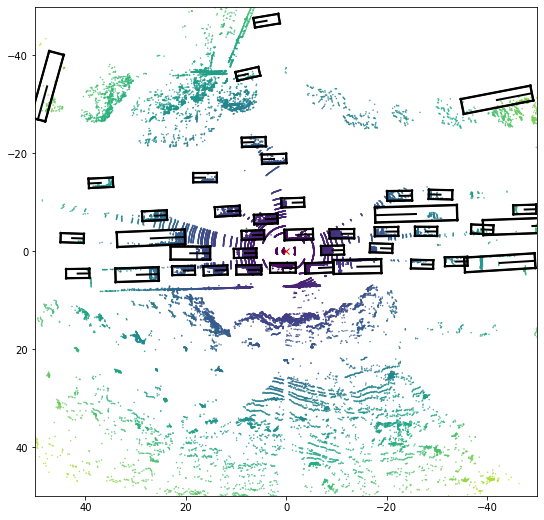

In [56]:
# plotting predicted and ground truth boxes on corresponding lidar point cloud
# pred boxes in lidar's, we get the ground truth boxes in lidar's too.
idx = 0
axes_limit=40
sample_token = pred_df.iloc[idx]['Id']
sample = lyft.get('sample', sample_token)
lidar = lyft.get('sample_data', sample['data']['LIDAR_TOP'])
path = os.path.join(root, 'data/lyft/train/', lidar['filename'])
points = np.fromfile(path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]
axes_limit = 50
_, ax = plt.subplots(1, 1, figsize=(9, 9))
dists = np.sqrt(np.sum(points[:, :2] ** 2, axis=1))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
ax.scatter(points[:, 0], points[:, 1], c=colors, s=0.2)
ax.plot(0, 0, "x", color="red")
# Limit visible range.
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)

for box in predBoxes[idx]:
    if box.score < 0.3: break
    box = glb_to_sensor(box, lidar)
    c = np.array(LyftDatasetExplorer.get_color('cone')) / 255.0 # black
    box.render(ax, view=np.eye(4), colors=(c, c, c))
    
for box in gtBoxes[idx]:
    break
    box = glb_to_sensor(box, lidar)
    c = np.array(LyftDatasetExplorer.get_color('pedestrian')) / 255.0 #blue 
    box.render(ax, view=np.eye(4), colors=(c, c, c))
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()

Detection score of the predicted boxes

In [57]:
for box in predBoxes[idx]:
    print(box.score)

0.9504448175430298
0.946792721748352
0.941006064414978
0.9342712759971619
0.9339845180511475
0.9320163726806641
0.927642285823822
0.9259523749351501
0.9126757383346558
0.9009630084037781
0.8915364146232605
0.8756511211395264
0.8705736994743347
0.8668262362480164
0.8487509489059448
0.8329550623893738
0.8281711935997009
0.8272998929023743
0.7813714742660522
0.6997488737106323
0.6595138907432556
0.6327340006828308
0.6271486282348633
0.6073861718177795
0.5974134802818298
0.5913729071617126
0.5838615298271179
0.5816789865493774
0.5423607230186462
0.5272225141525269
0.5182250738143921
0.5102968215942383
0.460081547498703
0.3738178312778473
0.3615979552268982
0.32074856758117676
0.31991666555404663
0.31287288665771484
0.30284085869789124
0.3005239963531494
0.26705601811408997
0.2653493583202362
0.2629496157169342
0.22850513458251953
0.22430071234703064
0.20988132059574127
0.20621949434280396


Ground truth annotated samples of the scene.

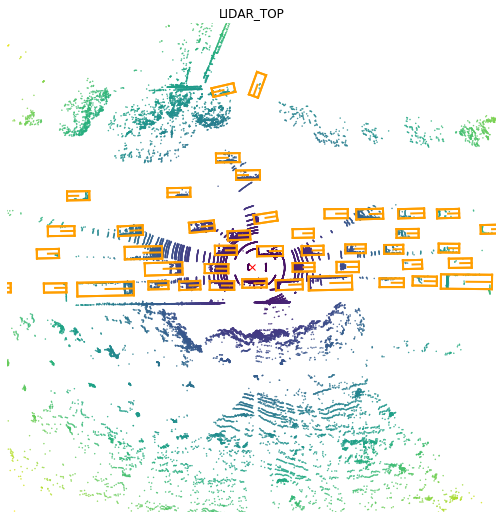

In [58]:
lyft.render_sample_data(lidar['token'], axes_limit=axes_limit)

In [59]:
lyft.get('sample', '7ff737ffb6f4d3adc01934f07178002543b6aab2352b1e3d0011a8a25ab00246')

{'next': '4f6f187cc6772acc3d98921643e4b700830c7e0d1df6872b9adbb72579587435',
 'prev': 'f15712d967ab919c6a89bb3b1bf73094541fb8994cff010509bd6b9192e743c1',
 'token': '7ff737ffb6f4d3adc01934f07178002543b6aab2352b1e3d0011a8a25ab00246',
 'scene_token': '71dfb15d2f88bf2aab2c5d4800c0d10a76c279b9fda98720781a406cbacc583b',
 'timestamp': 1558720201002204.2,
 'data': {'CAM_FRONT_RIGHT': '48f5cb208986bac3f3ba90326ec805323aac2b89017a34148b51e6d93f434eb7',
  'CAM_BACK': '5dd24df04e54c55071ff1b8b94e2b20f4dbc91305e62127e1b3e1d93afd67b4f',
  'LIDAR_FRONT_LEFT': '49f97552dcb1f6d23b24f87098f5be94ae535c674b60255411ce956cfb6dfbde',
  'LIDAR_FRONT_RIGHT': '9259a2f869cf7901274c09e46516c1796b93d1253086b640c1080b41899e11d0',
  'CAM_BACK_RIGHT': '45299445df5a54ea5c2968dd1d1dfd0fc18bfb467972474e0fde59ed056ed9be',
  'LIDAR_TOP': 'a62c10492e13215e32d4bd787d5a65304e07f0868449de3dd314b94c40909b0b',
  'CAM_BACK_LEFT': '2897fd1e7105a0f99dbacf9f973145a1422798b5d6ad30346063b04157aafafe',
  'CAM_FRONT': 'df9c7537ddd18444

In [61]:
info = token2info[token]
v_path = info["lidar_path"]
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]

In [62]:
sample = lyft.get('sample', info['token'])
lidar_token = sample['data']['LIDAR_TOP']

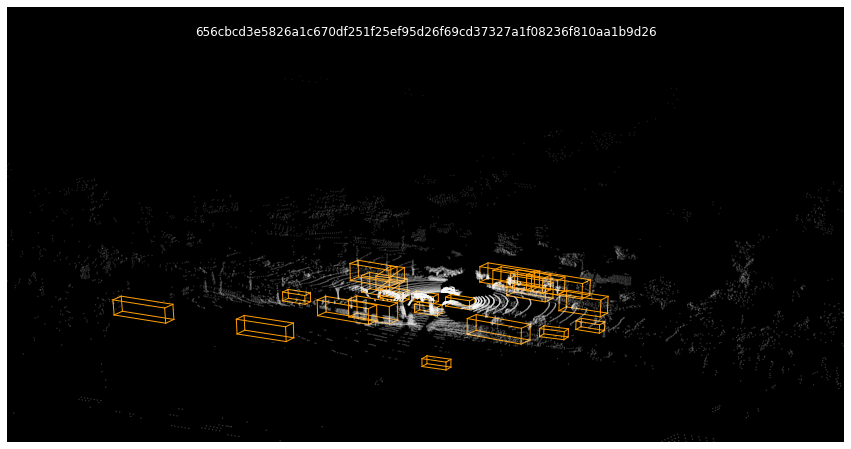

In [63]:
draw_3d_plot(lidar_token, boxes)

In [64]:
def plot_box(box, axis, view, colors, normalize=False, linewidth=1.0):
    '''Plot boxes in the 3d figure'''
    corners = view_points(box.corners(), view, normalize=normalize)#
    def draw_rect(selected_corners, color):
        prev = selected_corners[-1]
        for corner in selected_corners:
            axis.plot([prev[0], corner[0]], [prev[1], corner[1]], [prev[2], corner[2]], color=color, linewidth=linewidth)
            prev = corner

    # Draw the sides
    for i in range(4):
        axis.plot(
            [corners.T[i][0], corners.T[i + 4][0]],
            [corners.T[i][1], corners.T[i + 4][1]],
            [corners.T[i][2], corners.T[i + 4][2]],
            color=colors[2],
            linewidth=linewidth,
        )
    # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners.T[:4], colors[0]) #4x3
    draw_rect(corners.T[4:], colors[1])

We will Plot the lidar and annotations on a 3D figure

In [65]:
def draw_3d_plot(lidar_token, boxes):
    # sample lidar point cloud
    lidar_points = get_lidar_points(lidar_token)
    points = 0.5 # fraction of lidar_points to plot, to reduce the clutter
    points_step = int(1. / points)
    pc_range = range(0, lidar_points.shape[1], points_step)
    lidar_points = lidar_points[:, pc_range]
    
    # Get boxes, instead of current sensor's coordinate frame, use vehicle frame which is aligned to z-plane in world
    #_, boxes, _ = lyft.get_sample_data(
    #    lidar_token, flat_vehicle_coordinates=True
    #)
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')                    
    point_size = 0.01 * (1. / points) # size of the dots on plot
    ax.set_facecolor('black')
    ax.grid(False)
    ax.scatter(*lidar_points, s=point_size, c='white', cmap='gray')
    for box in boxes:
        c = np.array(lyft.explorer.get_color(box.name)) / 255.0
        plot_box(box, ax, view=np.eye(3), colors=(c, c, c), linewidth=1)
    ax.set_xlim3d(-40, 40)
    ax.set_ylim3d(-40, 40)
    ax.set_zlim3d(-4, 40)
    
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_title(lidar_token, color='white')
#     filename = 'tmp/frame_{0:0>4}.png'.format(idx)
#     plt.savefig(filename)
#     plt.close(fig)
    plt.show()
#     return filename

In [66]:
pc = draw_3d_plot(sample['data']['LIDAR_TOP'])

In [67]:
pred.keys()

dict_keys(['box3d_lidar', 'scores', 'label_preds', 'metadata'])

In [69]:
vis_voxel_size = [0.1, 0.1, 0.1]
vis_point_range = [-50, -30, -3, 50, 30, 1]
org_bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
bev_map = simplevis.draw_box_in_bev(org_bev_map.copy(), vis_point_range, boxes_lidar, [0, 255, 0], 2)

In [70]:
box3d_lidar = pred['box3d_lidar']
scores = pred['scores']
label_preds = pred['label_preds']
metadata = pred['metadata']

In [71]:
box3d_lidar.shape

torch.Size([188, 7])

In [73]:
label_preds

tensor([0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 6, 6, 2, 2, 6, 0, 0, 6, 6, 6, 2, 2,
        6, 6, 6, 6, 6, 6, 0, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6,
        6, 6, 2, 6, 2, 6, 6, 0, 6, 6, 6, 2, 2, 6, 6, 5, 6, 6, 6, 2, 2, 6, 6, 6,
        6, 2, 2, 6, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 6, 0, 6, 2, 6, 2, 6, 2, 6,
        6, 6, 6, 6, 5, 6, 6, 0, 6, 6, 0, 5, 2, 0, 1, 6, 6, 2, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 2, 6, 6, 6, 0, 6, 6, 6, 6, 6, 2, 0, 6, 2, 2, 6, 6, 6, 6, 6, 0,
        0, 6, 6, 6, 2, 6, 6, 0, 2, 5, 0, 6, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 2, 6, 2, 2, 6, 0, 6, 6, 2, 6, 6, 6, 2, 2, 6],
       device='cuda:0')

In [75]:
classes = target_assigner.classes

Predicted classes of the target assigner

In [76]:
classes = target_assigner.classes
preds = [classes[x] for x in label_preds]
preds

['car',
 'car',
 'car',
 'car',
 'car',
 'bus',
 'bus',
 'bus',
 'car',
 'bus',
 'bus',
 'bus',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'car',
 'car',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'car',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'pedestrian',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'car',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'pedestrian',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'car',


In [78]:
train.iloc[0]['PredictionString']

'2680.2830359778527 698.1969292852777 -18.04776692365821 2.064 5.488 2.053 2.6041643845397946 car 2691.997461646401 660.8016536569899 -18.674258695658377 1.818 4.57 1.608 -0.33517602468486984 car 2713.6075009338388 694.4034809694599 -18.589971933264334 1.779 4.992 1.62 2.579455758321168 car 2679.986916931015 706.9101495091695 -18.349594424165822 1.798 3.903 1.722 2.5861656766206993 car 2659.352095715659 719.4174623706303 -18.442998898501283 1.936 4.427 1.921 2.601798964714126 car 2705.199576267366 687.6053718669459 -18.13608710950738 1.849 4.586 1.801 2.6187666817281556 car 2712.706309822551 690.895857094069 -18.43179693610965 1.848 4.829 1.528 2.571936879901208 car 2755.5551865955817 646.2995181065994 -18.04141609089024 2.003 5.109 1.875 -0.5583518579067484 car 2721.868054568993 685.1596225679214 -17.64155351660436 2.539 7.671 3.287 2.609719767554756 truck 2723.602359479293 680.1666687198758 -17.298964332024624 2.557 7.637 3.594 2.598576712925146 truck 2683.980215118377 712.4764240778

### Now we will evaluate the our test

In [80]:
pred_df = pd.read_csv('submissions/all.fhd.2.val.csv')
# pred_df = val_df.copy()

In [81]:
pred_df.head()

,Id,PredictionString,PredictionStringtest
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...,0.9132686257362366 2719.266457575167 690.86441...
1,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...,0.9026079177856445 872.4775161488055 2564.1953...
2,4131c08a60bb7ad7fa66beb76f609d478571d508075a5a...,2775.313471140576 647.6817293876779 -18.164804...,0.9325973987579346 2681.6541244227205 705.8557...
3,7ff737ffb6f4d3adc01934f07178002543b6aab2352b1e...,2057.870673628988 1069.1471751137874 -18.38568...,0.9309068918228149 2030.8163891821255 1078.934...
4,5796b008cea965d2ff1d8f653d93b5d29aed64c22d6b89...,1426.2092077593366 1476.2266591045304 -21.5862...,0.914925217628479 1423.4485303394708 1473.6644...


In [83]:
def toBox3D(box, sample_token):
    return mAP_evaluation.Box3D(
                sample_token=sample_token,
                translation=box.center,
                size=box.wlh,
                rotation=box.orientation.elements,
                name=box.name
            )

def serialize(box):
    return {
        'sample_token': box.token,
        'translation': list(box.center),
        'size': list(box.wlh),
        'rotation': list(box.orientation.elements),
        'name': box.name,
        'score': box.score
    }

get all boxes per sample in a list

In [84]:
predBoxes = []
gtBoxes = []
for idx in tqdm(range(len(pred_df))):
    pb, gb = get_pred_gt(idx)
    predBoxes.append(pb)
    gtBoxes.append(gb)

100%|██████████| 4032/4032 [00:08<00:00, 499.30it/s] 


Box instance to Box3D instance -> used for mAP calculation

In [85]:
pboxes = []
for boxes in tqdm(predBoxes):
    for box in boxes:
        box = serialize(box)
        pboxes.append(box)
    
gboxes = []
for boxes in tqdm(gtBoxes):
    for box in boxes:
        box = serialize(box)
        gboxes.append(box)

100%|██████████| 4032/4032 [00:00<00:00, 4158.23it/s]


a dict with class name as key and all corresponding boxes in value

In [86]:
gt_by_class_name = mAP_evaluation.group_by_key(gboxes, "name")
pred_by_class_name = mAP_evaluation.group_by_key(pboxes, "name")

Now, let's take a look

In [87]:
for name in classes:
    print(name, 'gt/pred:', len(gt_by_class_name[name]), len(pred_by_class_name[name]))

car gt/pred: 93364 76825
bicycle gt/pred: 2949 1578
animal gt/pred: 72 0
bus gt/pred: 2133 1564
emergency_vehicle gt/pred: 0 0
other_vehicle gt/pred: 6916 6377
motorcycle gt/pred: 145 4
pedestrian gt/pred: 3876 2077
truck gt/pred: 2073 1990


In [88]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import *

In [89]:
class_name = 'bus'
gt = gt_by_class_name[class_name]
predictions = pred_by_class_name[class_name]
iou_threshold = 0.2
num_gts = len(gt)
image_gts = group_by_key(gt, "sample_token")
image_gts = wrap_in_box(image_gts)

sample_gt_checked = {sample_token: np.zeros(len(boxes)) for sample_token, boxes in image_gts.items()}

predictions = sorted(predictions, key=lambda x: x["score"], reverse=True)

# go down dets and mark TPs and FPs
num_predictions = len(predictions)
tp = np.zeros(num_predictions)
fp = np.zeros(num_predictions)

Total 1564 predictions, they can either be TP(true positive) or FP(false positive)

In [90]:
len(gt), len(predictions) 

(2133, 1564)

In [92]:
for prediction_index, prediction in enumerate(tqdm(predictions)):
    # take each prediction
    predicted_box = Box3D(**prediction)

    sample_token = prediction["sample_token"]

    max_overlap = -np.inf
    jmax = -1

    try:
        gt_boxes = image_gts[sample_token]  # gt_boxes per sample
        gt_checked = sample_gt_checked[sample_token]  # gt flags per sample
    except KeyError:
        gt_boxes = []
        gt_checked = None

    if len(gt_boxes) > 0:
        # get overlap of this predicted box with all the ground truths
        overlaps = get_ious(gt_boxes, predicted_box)
        # get the one, with which it has the maximum overlap
        max_overlap = np.max(overlaps)
        jmax = np.argmax(overlaps)

    if max_overlap > iou_threshold: # the max overlapping box qualifies the threshold
        if gt_checked[jmax] == 0: # if this gt box isn't checked (already identified by a pred box)
            tp[prediction_index] = 1.0
            gt_checked[jmax] = 1
        else: # if this pred box was already "assigned" to any ground truth, then you predicted a box close to the ground truth, but there was another box predicted which was better
            # so this is a false positive
            fp[prediction_index] = 1.0
    else: # there was no ground truth for this predictions
        fp[prediction_index] = 1.0


100%|██████████| 1564/1564 [00:00<00:00, 3798.51it/s]


In [93]:
fp.sum(), tp.sum()

(1288.0, 276.0)

Compute precision recall

In [95]:
fp = np.cumsum(fp, axis=0)
tp = np.cumsum(tp, axis=0)

Cummulative sum

In [96]:
fp, tp

(array([1.000e+00, 2.000e+00, 2.000e+00, ..., 1.286e+03, 1.287e+03,
        1.288e+03]), array([  0.,   0.,   1., ..., 276., 276., 276.]))

num_gts = total positives, there's no TN predictions. We have FN though but not in predicted boxes but in ground truths.

In [98]:
recalls = tp / float(num_gts) 

In [99]:
recalls

array([0.        , 0.        , 0.00046882, ..., 0.12939522, 0.12939522,
       0.12939522])

Let's plot recall graph

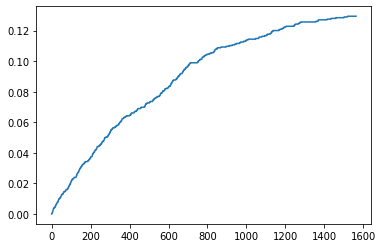

In [101]:
plt.plot(recalls)

We have to avoid divide by zero in case the first detection matches a difficult ground truth

In [103]:
precisions = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)

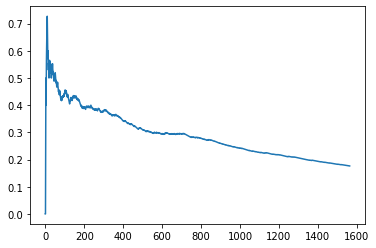

In [104]:
plt.plot(precisions)

 precision vs recall, is for a given recall max to min values of precision
<img width="500" height="500" src="https://miro.medium.com/max/1504/1*VenTq4IgxjmIpOXWdFb-jg.png"></img>

Correct AP calculation
First append sentinel values at the end

In [106]:
recalls = np.concatenate(([0.0], recalls, [1.0]))
precisions = np.concatenate(([0.0], precisions, [0.0]))

In [107]:
recalls, precisions

(array([0.        , 0.        , 0.        , ..., 0.12939522, 0.12939522,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.17658349, 0.17647059,
        0.        ]))

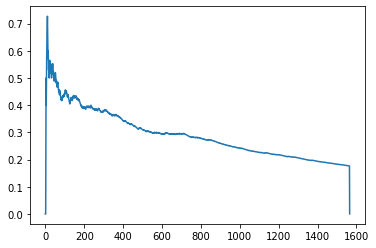

In [109]:
plt.plot(precisions)

In [111]:
for i in range(precisions.size - 1, 0, -1):
    precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

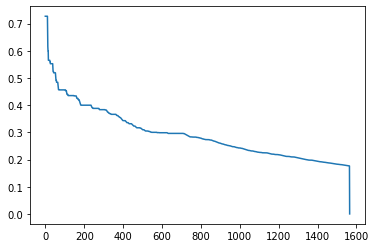

In [112]:
plt.plot(precisions)

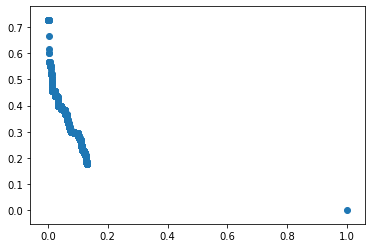

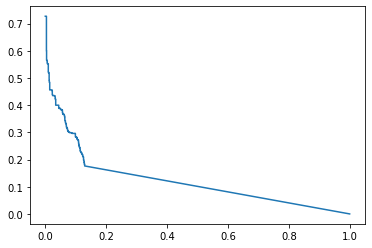

In [114]:
plt.scatter(recalls, precisions); plt.show()
plt.plot(recalls, precisions); plt.show()

To calculate area under precision-recall curve, look for points where X axis (recall) changes value

In [115]:
i = np.where(recalls[1:] != recalls[:-1])[0]

In [116]:
(recalls[1:] != recalls[:-1])

array([False, False,  True, ..., False, False,  True])

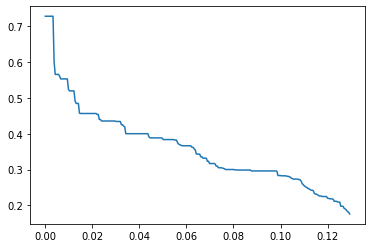

In [118]:
plt.plot(recalls[i], precisions[i]); plt.show()

And sum (\Delta recall) * prec

In [119]:
ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])

Average precision for the prediction results.

In [120]:
ap

0.04677945150868475

In [122]:
time_start = time.time()
average_precisions = get_average_precisions(gt, pr_corr, class_names, 0.01)
ap = np.mean(average_precisions)
print("Average precision(ap) per class  = ", ap)
for classes in sorted(list(zip(class_names, average_precisions.flatten().tolist()))):
    print(class_id)
print("Time to evaluate = ", time.time() - time_start)  

Average precision(ap) per class  = =  0.04677945150868475
('animal', 0.5635474928139182)
('bicycle', 0.179182281439182)
('bus', 0.44281841841201874)
('car', 0.71291839182195813)
('emergency_vehicle', 0.519182742817413812)
('motorcycle', 0.562817429182218312)
('other_vehicle', 0.61281824817428173)
('pedestrian', 0.09182713817217486)
('truck', 0.54183731722817461)
Time to evaluate =  54.726143712741726
